In [53]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters, StatsBase, Distributions

include("../utils/import.jl")
using .Import

include("../utils/figs.jl")
using .Figs

fig_directory = "../fig/"
filetype = ".png"
function save(name::String)
    savefig(fig_directory*name*filetype)
end

save (generic function with 1 method)

# LONG runs

**Parameters:**\
steps: 1000\
lookahead: 5\
runs: 20

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
active infinite: 2.5h\
passive infinite: 2.5h\
active finite: 3.5h\
passive finite: 3.5h\
random: 6m\
arms: 6m\
naive-50: 5m\
naive-100: 5m\
naive-200: 5m

In [33]:
# Experiment parameters
runs = 20
actions = ["C1", "C2", "C3", "C4", "B1", "B2", "B3", "B"]
afc, aic, aiu, pfc, pic = "active finite", "active infinite", "active infinite (unconstrained)", "passive finite", "passive infinite"
rn, ra, n50, n100, n200 = "random", "random arms", "naive-50", "naive-100", "naive-200"
aics, pics, n50s = "active infinite (new states)", "passive infinite (new states)", "naive-50 (new states)"
aicd, picd, n50d = "active infinite (no dupes)", "passive infinite (no dupes)", "naive-50 (no dupes)"
aica, n50a = "active infinite (5 arms)", "naive (5 arms)"

# Plotting Parameters
labels = [aicd, aic, picd, pic, n50d, n50]
discount = 0.999
window = 10
;

In [38]:
## Previous experiments ##

# afc: active, finite, constrained
ids_afc = ["active_finite_23331_22581", "active_finite_23331_230912", "active_finite_23331_23194", "active_finite_23331_232832", "active_finite_23331_233745", "active_finite_23331_234620", "active_finite_23331_235559", "active_finite_2341_00042", "active_finite_2341_001352", "active_finite_2341_002354", "active_finite_2341_003143", "active_finite_2341_003937", "active_finite_2341_004937", "active_finite_2341_005730", "active_finite_2341_010754", "active_finite_2341_011826", "active_finite_2341_012934", "active_finite_2341_013739", "active_finite_2341_014528", "active_finite_2341_015325"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_23331_173929", "active_infinite_23331_174758", "active_infinite_23331_175550", "active_infinite_23331_180158", "active_infinite_23331_180838", "active_infinite_23331_18164", "active_infinite_23331_182331", "active_infinite_23331_183051", "active_infinite_23331_183832", "active_infinite_23331_18475", "active_infinite_23331_185539", "active_infinite_23331_190344", "active_infinite_23331_191151", "active_infinite_23331_19184", "active_infinite_23331_192554", "active_infinite_23331_194737", "active_infinite_23331_195422", "active_infinite_23331_200216", "active_infinite_23331_200820", "active_infinite_23331_201429"] 

# aiu: active, infinite, unconstrained
ids_aiu = ["active_infinite_2347_133639", "active_infinite_2347_13454", "active_infinite_2347_135340", "active_infinite_2347_140151", "active_infinite_2347_140951", "active_infinite_2347_141812", "active_infinite_2347_142648", "active_infinite_2347_14330", "active_infinite_2347_14415", "active_infinite_2347_144835", "active_infinite_2347_145636", "active_infinite_2347_150256", "active_infinite_2347_150911", "active_infinite_2347_151523", "active_infinite_2347_152138", "active_infinite_2347_152759", "active_infinite_2347_153611", "active_infinite_2347_154229", "active_infinite_2347_155045", "active_infinite_2347_155836"]

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_020331", "passive_finite_2341_021258", "passive_finite_2341_022038", "passive_finite_2341_022957", "passive_finite_2341_023919", "passive_finite_2341_024851", "passive_finite_2341_02583", "passive_finite_2341_030527", "passive_finite_2341_031352", "passive_finite_2341_032256", "passive_finite_2341_033150", "passive_finite_2341_034040", "passive_finite_2341_034844", "passive_finite_2341_03568", "passive_finite_2341_040431", "passive_finite_2341_041158", "passive_finite_2341_041938", "passive_finite_2341_042739", "passive_finite_2341_04373", "passive_finite_2341_044432"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_23331_202225", "passive_infinite_23331_202939", "passive_infinite_23331_203640", "passive_infinite_23331_204346", "passive_infinite_23331_20514", "passive_infinite_23331_205811", "passive_infinite_23331_21041", "passive_infinite_23331_211040", "passive_infinite_23331_211639", "passive_infinite_23331_21247", "passive_infinite_23331_212956", "passive_infinite_23331_213613", "passive_infinite_23331_214235", "passive_infinite_23331_215023", "passive_infinite_23331_215646", "passive_infinite_23331_220450", "passive_infinite_23331_221250", "passive_infinite_23331_222018", "passive_infinite_23331_222659", "passive_infinite_23331_223256"]

# r: random
ids_r = ["random_2343_12335", "random_2343_123324", "random_2343_123344", "random_2343_12345", "random_2343_123425", "random_2343_123444", "random_2343_12354", "random_2343_123524", "random_2343_123543", "random_2343_12364", "random_2343_123624", "random_2343_123645", "random_2343_12375", "random_2343_123724", "random_2343_123745", "random_2343_12385", "random_2343_123825", "random_2343_123845", "random_2343_12395", "random_2343_123925"]

# ra: random arms
ids_ra = ["arms_2343_12539", "arms_2343_125329", "arms_2343_125349", "arms_2343_12549", "arms_2343_125428", "arms_2343_125448", "arms_2343_12558", "arms_2343_125527", "arms_2343_125547", "arms_2343_12567", "arms_2343_125627", "arms_2343_125646", "arms_2343_12576", "arms_2343_125726", "arms_2343_125745", "arms_2343_12584", "arms_2343_125823", "arms_2343_125842", "arms_2343_12592", "arms_2343_125921"]

# n50: naive with explore_timesteps = 50
ids_n50 = ["naive_50_2347_121158", "naive_50_2347_121215", "naive_50_2347_121232", "naive_50_2347_121249", "naive_50_2347_12136", "naive_50_2347_121323", "naive_50_2347_121339", "naive_50_2347_121356", "naive_50_2347_121414", "naive_50_2347_121431", "naive_50_2347_121448", "naive_50_2347_12155", "naive_50_2347_121523", "naive_50_2347_121540", "naive_50_2347_121557", "naive_50_2347_121614", "naive_50_2347_121631", "naive_50_2347_121648", "naive_50_2347_12175", "naive_50_2347_121722"]

# n100: naive with explore_timesteps = 100
ids_n100 = ["naive_100_2347_121858", "naive_100_2347_121914", "naive_100_2347_121931", "naive_100_2347_121948", "naive_100_2347_12205", "naive_100_2347_122022", "naive_100_2347_122039", "naive_100_2347_122056", "naive_100_2347_122112", "naive_100_2347_122129", "naive_100_2347_122146", "naive_100_2347_12222", "naive_100_2347_122219", "naive_100_2347_122236", "naive_100_2347_122253", "naive_100_2347_12239", "naive_100_2347_122326", "naive_100_2347_122343", "naive_100_2347_12240", "naive_100_2347_122417"]

# n200: naive with explore_timesteps = 200
ids_n200 = ["naive_200_2347_122512", "naive_200_2347_122528", "naive_200_2347_122545", "naive_200_2347_12261", "naive_200_2347_122617", "naive_200_2347_122634", "naive_200_2347_122650", "naive_200_2347_12276", "naive_200_2347_122723", "naive_200_2347_122739", "naive_200_2347_122756", "naive_200_2347_122812", "naive_200_2347_122828", "naive_200_2347_122845", "naive_200_2347_12291", "naive_200_2347_122918", "naive_200_2347_122934", "naive_200_2347_122950", "naive_200_2347_12307", "naive_200_2347_123023"]

## Harder ##

# aics: active, infinite, constrained, new states
ids_aics = ["active_infinite_2348_150751", "active_infinite_2348_151533", "active_infinite_2348_152153", "active_infinite_2348_152926", "active_infinite_2348_153659", "active_infinite_2348_154429"]

# picn: passive, infinite, constrained, new states
ids_pics = ["passive_infinite_2348_155638", "passive_infinite_2348_160415", "passive_infinite_2348_161124", "passive_infinite_2348_161850", "passive_infinite_2348_16261", "passive_infinite_2348_16330"]

# n50s: naive with explore_timesteps = 50, new states
ids_n50s = ["naive_50_2348_171751", "naive_50_2348_17187", "naive_50_2348_171823", "naive_50_2348_171839", "naive_50_2348_171855", "naive_50_2348_171912"]

# aicd: active, infinite, constrained, no dupes in state space
ids_aicd = ["active_infinite_23410_133224", "active_infinite_23410_134112", "active_infinite_23410_13484", "active_infinite_23410_13578", "active_infinite_23410_140534", "active_infinite_23410_141422"]

# picn: passive, infinite, constrained, no dupes in state space
ids_picd = ["passive_infinite_23410_14253", "passive_infinite_23410_14326", "passive_infinite_23410_143856", "passive_infinite_23410_144539", "passive_infinite_23410_145247", "passive_infinite_23410_14586"]

# n50s: naive with explore_timesteps = 50, no dupes in state space
ids_n50d = ["naive_50_23410_151812", "naive_50_23410_151828", "naive_50_23410_151844", "naive_50_23410_15191", "naive_50_23410_151917", "naive_50_23410_151932"]

# aica: active, infinite, constrained, more arms & no dupes in state space
ids_aica = ["active_infinite_23410_15325", "active_infinite_23410_154043", "active_infinite_23410_154914", "active_infinite_23410_15586", "active_infinite_23410_160550", "active_infinite_23410_161425", "active_infinite_23410_16230", "active_infinite_23410_163127", "active_infinite_23410_164032", "active_infinite_23410_164926", "active_infinite_23410_16581", "active_infinite_23410_171834"]

# n50a: naive with explore_timesteps = 50, more arms & no dupes in state space
ids_n50a = ["naive_50_23411_085843", "naive_50_23411_08590", "naive_50_23411_085918", "naive_50_23411_085936", "naive_50_23411_085953", "naive_50_23411_090010", "naive_50_23411_090027", "naive_50_23411_090044", "naive_50_23411_09012", "naive_50_23411_090119", "naive_50_23411_090136", "naive_50_23411_090153"]

# s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
# s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
# s_aiu, t_aiu, a_aiu, r_aiu = Import.import_IDs(ids_aiu, runs, directory="..")
# s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
# s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
# s_r, t_r, a_r, r_r = Import.import_IDs(ids_r, runs, directory="..")
# s_ra, t_ra, a_ra, r_ra = Import.import_IDs(ids_ra, runs, directory="..")
# s_n50, t_n50, a_n50, r_n50 = Import.import_IDs(ids_n50, runs, directory="..")
# s_n100, t_n100, a_n100, r_n100 = Import.import_IDs(ids_n100, runs, directory="..")
# s_n200, t_n200, a_n200, r_n200 = Import.import_IDs(ids_n200, runs, directory="..")

# s_aics, t_aics, a_aics, r_aics = Import.import_IDs(ids_aics, runs, directory="..")
# s_pics, t_pics, a_pics, r_pics = Import.import_IDs(ids_pics, runs, directory="..")
# s_n50s, t_n50s, a_n50s, r_n50s = Import.import_IDs(ids_n50s, runs, directory="..")
# s_aicd, t_aicd, a_aicd, r_aicd = Import.import_IDs(ids_aicd, runs, directory="..")
# s_picd, t_picd, a_picd, r_picd = Import.import_IDs(ids_picd, runs, directory="..")
# s_n50d, t_n50d, a_n50d, r_n50d = Import.import_IDs(ids_n50d, runs, directory="..")
s_aica, t_aica, a_aica, r_aica = Import.import_IDs(ids_aica, 25, directory="..")
s_n50a, t_n50a, a_n50a, r_n50a = Import.import_IDs(ids_n50a, 25, directory="..")
;

In [39]:
a_aica[1][1:100]

100-element Vector{Any}:
 "C3"
 "C3"
 "C4"
 "C4"
 "C5"
 "C4"
 "C3"
 "C3"
 "C2"
 "C1"
 "C2"
 "C3"
 "C2"
 ⋮
 "C2"
 "C1"
 "C5"
 "C2"
 "C1"
 "C2"
 "C5"
 "C2"
 "C3"
 "C5"
 "C3"
 "C2"

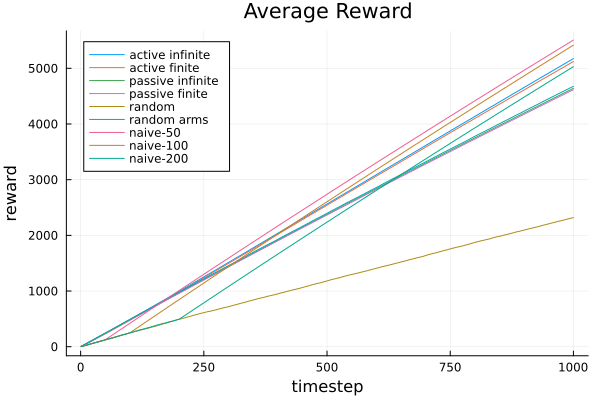

In [62]:
r = [r_aic, r_afc, r_pic, r_pfc, r_r, r_ra, r_n50, r_n100, r_n200]
labels = [aic afc pic pfc rn ra n50 n100 n200]
Figs.plot_cumulative_avg_r_multiple_experiments(r, 0.9999, labels, "Average Reward")

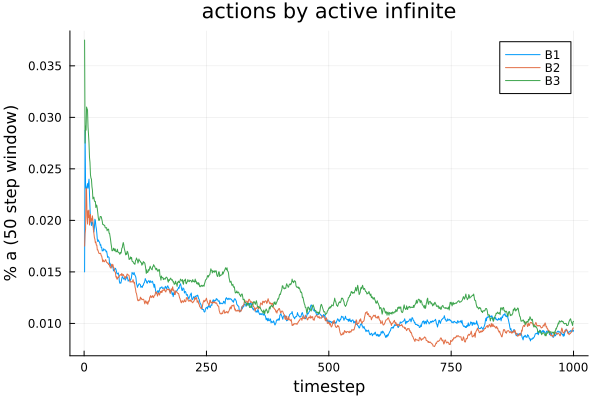

In [61]:
alg = aic
act = a_aic
Figs.plot_proportion_actions_all(act, ["B1", "B2", "B3"], 50, "actions by "*alg)

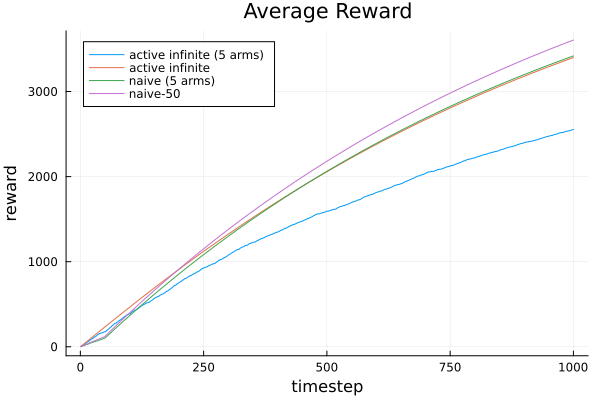

In [40]:
# r = [[r_aica[1]], r_aic, r_n50a, r_n50]
labels = [aica aic n50a n50]
Figs.plot_cumulative_avg_r_multiple_experiments(r, discount, labels, "Average Reward")

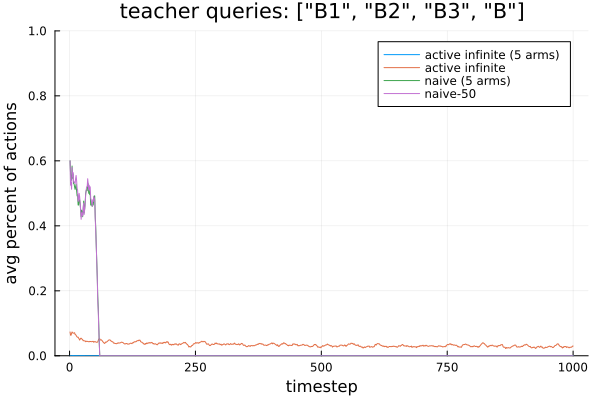

In [41]:
a = [a_aica, a_aic, a_n50a, a_n50]
labels = [aica aic n50a n50]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

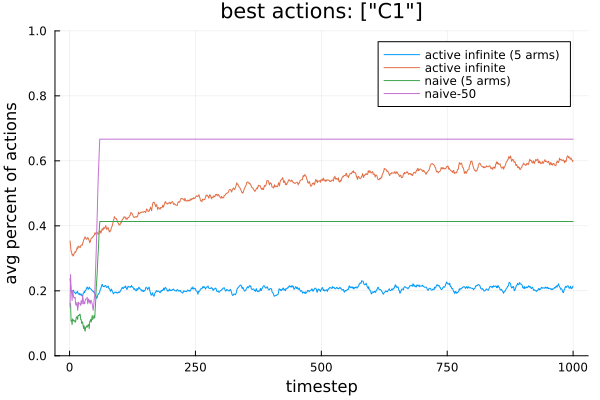

In [42]:
a = [a_aica, a_aic, a_n50a, a_n50]
labels = [aica aic n50a n50]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["C1"], window, labels, "best actions: ")

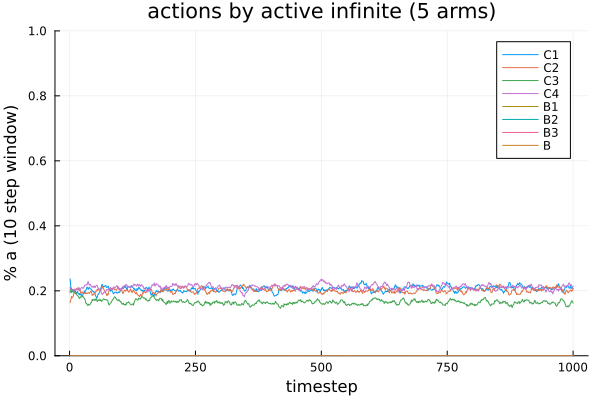

In [43]:
alg = aica
act = a_aica
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

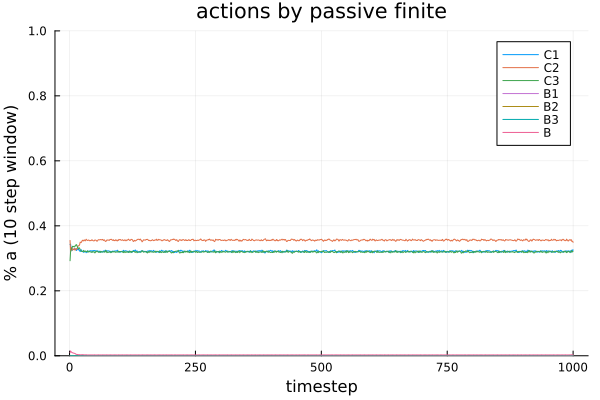

In [36]:
alg = pfc
act = a_pfc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)